<a href="https://colab.research.google.com/github/Vibhuarvind/Depression-Detect/blob/main/Facial/FER_Simple_Architecture_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### General imports ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
import h5py
from keras.models import model_from_json
import pickle

In [ ]:
path = '/content/drive/MyDrive/'
local_path = '/content/drive/MyDrive/'

In [ ]:
X_train = np.load(local_path + "X_train.npy")
X_test = np.load(local_path + "X_test.npy")
y_train = np.load(local_path + "y_train.npy")
y_test = np.load(local_path + "y_test.npy")

In [ ]:
shape_x = 48
shape_y = 48
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)
classes = np.unique(y_train)
nClasses = len(classes)

In [ ]:
y_train.shape

(28709, 7)

In [ ]:
class_weight = {
    0:1/sum(y_train[:,0]), 
    1:sum(y_train[:,1]), 
    2:sum(y_train[:,2]), 
    3:sum(y_train[:,3]),
    4:sum(y_train[:,4]),
    5:sum(y_train[:,5]),
    6:sum(y_train[:,6])
}

In [ ]:
def createModel():
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48,48,1)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))

    return model

In [ ]:
model = createModel()

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       7

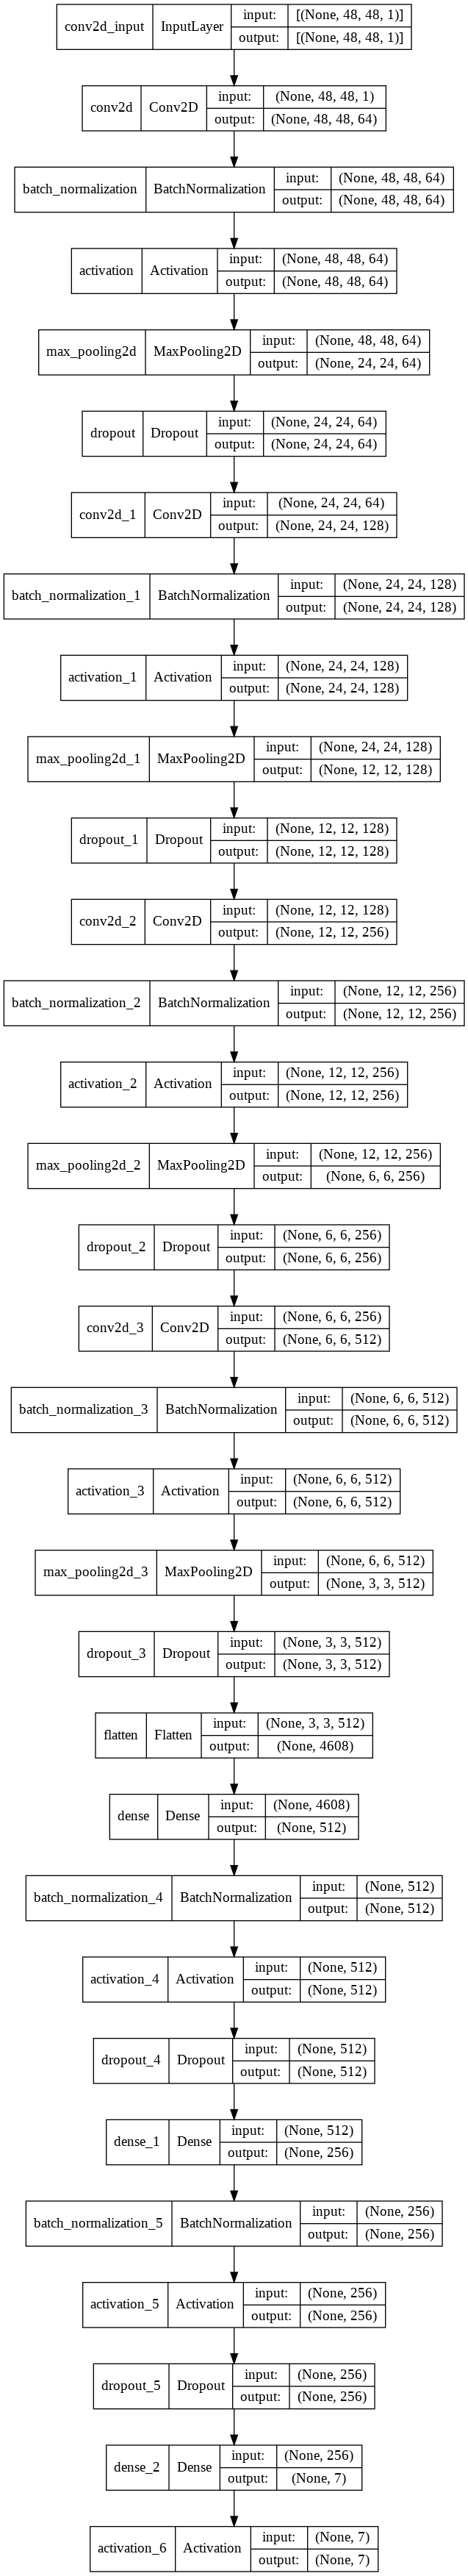

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
datagen = ImageDataGenerator(
        zoom_range=0.2,          # randomly zoom into images
        rotation_range=10,       # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,   # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,    # randomly flip images
        vertical_flip=False)     # randomly flip images

In [ ]:
# augment and fit data
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    shear_range=0,
    zoom_range=0.0,
    horizontal_flip=True,
    vertical_flip=False)
datagen.fit(X_train)

In [ ]:
#Creating 2nd model and training(fitting)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
batch_size = 128
epochs = 50

# Fit the model on the batches generated by datagen.flow().
history = model.fit_generator(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
    epochs = epochs, 
    validation_data=(X_test, y_test), class_weight=class_weight)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/50
 37/225 [===>..........................] - ETA: 8:04 - loss: 7891.8853 - accuracy: 0.2461

KeyboardInterrupt: ignored

In [ ]:
#Plotting accuracy and loss curves for 2nd model

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=2.0)
plt.plot(history.history['val_acc'],'b',linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

NameError: ignored

<Figure size 576x432 with 0 Axes>

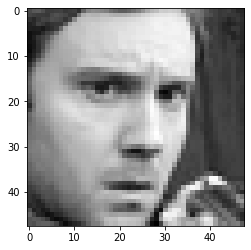

In [ ]:
im = X_train[0].reshape(48,48)
plt.imshow(im, 'gray')

In [ ]:
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

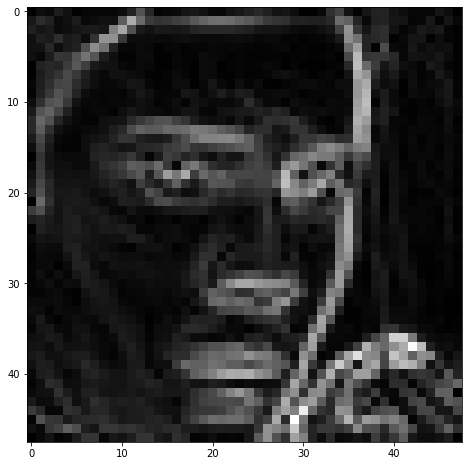

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(mag, 'gray')
plt.show()

In [ ]:
#save the model weights
json_string = model.to_json()
model.save_weights(local_path + 'models/model_simple_2.h5')
open(local_path + 'models/model_simple_2.json', 'w').write(json_string)
#model.save_weights(local_path + 'savedmodels/Emotion_Face_Detection_Model.h5')

9906

In [ ]:
with open(local_path + 'models/model_simple_2.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(local_path + 'models/model_simple_2.h5')
print("Loaded model from disk")

Loaded model from disk
